# 🧛 Day 10 — Ghost Detector on Images (Spooky vs Normal)

Series: 30 Days – 30 Data Science Projects
Goal: Classify images into Spooky Halloween decorations vs Normal home scenes and output a playful “Haunted Level” using MobileNetV2 (PyTorch).

In [2]:
# If running in a fresh environment, uncomment:
!pip install -q torch torchvision scikit-learn matplotlib pillow bing-image-downloader gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 88.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 66.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.2 MB/s eta 0:00:0000:0100:02m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 25.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━

## 📝 Step 1 — Imports & Setup

In [10]:
!ls /kaggle/input

lol-dataset


In [12]:
# ===== Robust LOL-only dataset wiring (auto-discovery) =====
import os, shutil, random, re
from pathlib import Path
from PIL import Image
import numpy as np

SEED = 42
random.seed(SEED); np.random.seed(SEED)

RAW_DIR   = Path("data/raw")
SP_DIR    = RAW_DIR / "spooky"
NM_DIR    = RAW_DIR / "normal"
SPLIT_DIR = Path("data/split")

for d in [SP_DIR, NM_DIR]:
    d.mkdir(parents=True, exist_ok=True)

def reset_dir(p: Path):
    if p.exists():
        shutil.rmtree(p)
    p.mkdir(parents=True, exist_ok=True)

def is_img(p: Path):
    return p.is_file() and p.suffix.lower() in {".jpg",".jpeg",".png",".bmp",".webp"}

def safe_copy(sample_paths, dst_dir: Path, max_count=None):
    dst_dir.mkdir(parents=True, exist_ok=True)
    files = [p for p in sample_paths if is_img(p)]
    random.shuffle(files)
    if max_count: files = files[:max_count]
    copied = 0
    for p in files:
        try:
            Image.open(p).convert("RGB")
            shutil.copy2(p, dst_dir / p.name)
            copied += 1
        except Exception:
            pass
    return copied

def first_existing(paths):
    for p in paths:
        if Path(p).exists():
            return Path(p)
    return None

# 1) Find LOL root (no assumptions about substructure)
lol_root = first_existing([
    "/kaggle/input/lol-dataset",
    "/kaggle/input/soumikrakshit-lol-dataset",
    "/kaggle/input/soumikrakshit/lol-dataset",
])
if lol_root is None:
    raise SystemExit("❌ LOL dataset not found. Attach it in the right sidebar (Add data).")

print("LOL root:", lol_root)

# 2) Crawl for image folders and bucket them by folder name keywords
#    Any folder path containing 'low' → spooky; containing 'high' or 'normal' → normal.
low_like    = re.compile(r"(?:^|/)(low)(?:/|$)", re.IGNORECASE)
normal_like = re.compile(r"(?:^|/)(high|normal)(?:/|$)", re.IGNORECASE)

spooky_dirs  = set()
normal_dirs  = set()
img_dirs     = set()

for dirpath, dirnames, filenames in os.walk(lol_root):
    if any(fn.lower().endswith((".jpg",".jpeg",".png",".bmp",".webp")) for fn in filenames):
        p = Path(dirpath)
        img_dirs.add(p)
        if low_like.search(str(p).replace("\\","/")):
            spooky_dirs.add(p)
        elif normal_like.search(str(p).replace("\\","/")):
            normal_dirs.add(p)

print(f"Found {len(img_dirs)} image-bearing folders under LOL.")
print(f"→ Candidate LOW (spooky) folders: {len(spooky_dirs)}")
print(f"→ Candidate HIGH/NORMAL folders: {len(normal_dirs)}")

# 3) If the dataset uses some other naming, fall back to pairing heuristics:
#    If we found nothing, treat all image dirs as spooky OR normal won’t work; so we enforce at least one of each.
if not spooky_dirs and not normal_dirs:
    # Try common known patterns
    for p in img_dirs:
        s = str(p).lower().replace("\\","/")
        if "/low" in s:
            spooky_dirs.add(p)
        if "/high" in s or "/normal" in s:
            normal_dirs.add(p)

print("After heuristics:")
print("Spooky dirs:", len(spooky_dirs))
print("Normal dirs:", len(normal_dirs))

if not spooky_dirs or not normal_dirs:
    # As a last resort, split all image dirs into two buckets by darkness of folder name
    # but better to inspect the structure:
    print("⚠️ Could not confidently find both classes by folder name.")
    print("Listing a few image folders to help you verify:")
    for i, p in enumerate(sorted(img_dirs)[:20]):
        print("  ", i+1, p)
    raise SystemExit("❌ Could not find both low (spooky) and high/normal folders. Check the printed folders above and tell me which ones map to spooky/normal.")

# 4) Collect image files from discovered dirs
MAX_PER_CLASS = 2000  # cap to keep classes balanced & training fast
spooky_files = []
normal_files = []
for d in spooky_dirs:
    spooky_files.extend([Path(d)/f for f in os.listdir(d) if is_img(Path(d)/f)])
for d in normal_dirs:
    normal_files.extend([Path(d)/f for f in os.listdir(d) if is_img(Path(d)/f)])

print(f"Discovered candidate files → spooky: {len(spooky_files)} | normal: {len(normal_files)}")

# 5) Populate data/raw
reset_dir(SP_DIR)
reset_dir(NM_DIR)
n_sp = safe_copy(spooky_files, SP_DIR, max_count=MAX_PER_CLASS)
n_nm = safe_copy(normal_files, NM_DIR, max_count=MAX_PER_CLASS)
print(f"RAW counts copied → spooky: {n_sp} | normal: {n_nm}")

if n_sp == 0 or n_nm == 0:
    raise SystemExit("❌ Copy step yielded 0 images for a class. Please share the printed folder list so I can tune the matcher.")

LOL root: /kaggle/input/lol-dataset
Found 4 image-bearing folders under LOL.
→ Candidate LOW (spooky) folders: 2
→ Candidate HIGH/NORMAL folders: 2
After heuristics:
Spooky dirs: 2
Normal dirs: 2
Discovered candidate files → spooky: 500 | normal: 500
RAW counts copied → spooky: 500 | normal: 500


## ✂️ Step 3 — Train/Val/Test Split (70% / 15% / 15%)

In [13]:
# Split into train/val/test
import shutil, random
from pathlib import Path

RAW_DIR   = Path("data/raw")
SPLIT_DIR = Path("data/split")
classes = ["normal","spooky"]

def reset_dir(p: Path):
    if p.exists():
        shutil.rmtree(p)
    p.mkdir(parents=True, exist_ok=True)

def split_dataset(raw_dir=RAW_DIR, split_dir=SPLIT_DIR, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, seed=42):
    random.seed(seed)
    reset_dir(split_dir)
    for split in ["train","val","test"]:
        for cls in classes:
            (split_dir / split / cls).mkdir(parents=True, exist_ok=True)

    for cls in classes:
        files = [p for p in (raw_dir/cls).glob("*") if p.is_file()]
        random.shuffle(files)
        n = len(files)
        n_train = int(n*train_ratio); n_val = int(n*val_ratio)
        parts = {
            "train": files[:n_train],
            "val"  : files[n_train:n_train+n_val],
            "test" : files[n_train+n_val:]
        }
        for split, lst in parts.items():
            for src in lst:
                try:
                    shutil.copy2(src, split_dir / split / cls / src.name)
                except Exception:
                    pass
    return split_dir

SPLIT_DIR = split_dataset()

for split in ["train","val","test"]:
    counts = {c: len(list((SPLIT_DIR/split/c).glob("*"))) for c in classes}
    print(split, counts)

train {'normal': 350, 'spooky': 350}
val {'normal': 75, 'spooky': 75}
test {'normal': 75, 'spooky': 75}


## 🧠 Step 4 — DataLoaders + Transformations

In [14]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

IMG_SIZE = 224
BATCH = 16

train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])
val_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

train_ds = datasets.ImageFolder(str(SPLIT_DIR / "train"), transform=train_tfms)
val_ds   = datasets.ImageFolder(str(SPLIT_DIR / "val"),   transform=val_tfms)
test_ds  = datasets.ImageFolder(str(SPLIT_DIR / "test"),  transform=val_tfms)

train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True,  num_workers=2, pin_memory=(DEVICE.type=="cuda"))
val_loader   = DataLoader(val_ds,   batch_size=BATCH, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_ds,  batch_size=BATCH, shuffle=False, num_workers=2)

class_names = train_ds.classes
print("Classes:", class_names, "| train:", len(train_ds), "val:", len(val_ds), "test:", len(test_ds))

Device: cpu
Classes: ['normal', 'spooky'] | train: 700 val: 150 test: 150


## 🔥 Step 5 — Train Model (MobileNetV2 Transfer Learning)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 120MB/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 01 | train_loss=0.1886 acc=0.924 | val_loss=0.0569 acc=0.993
Epoch 02 | train_loss=0.0640 acc=0.980 | val_loss=0.0584 acc=0.987
Epoch 03 | train_loss=0.0384 acc=0.986 | val_loss=0.0723 acc=0.973
Epoch 04 | train_loss=0.0675 acc=0.981 | val_loss=0.0928 acc=0.980
Epoch 05 | train_loss=0.0280 acc=0.993 | val_loss=0.0726 acc=0.980
Early stopping.


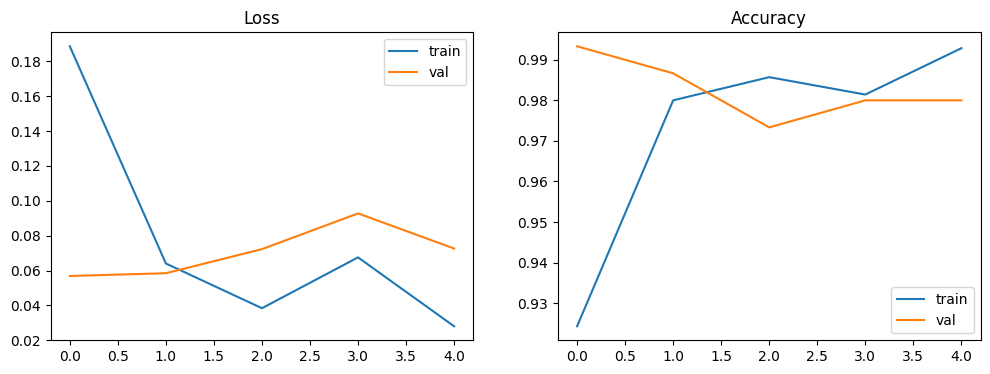

In [15]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, 2)
model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

def run_epoch(loader, train_mode=True):
    model.train() if train_mode else model.eval()
    losses, preds_all, targets_all = [], [], []
    for (x, y) in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad(set_to_none=True)
        with torch.set_grad_enabled(train_mode):
            logits = model(x)
            loss = criterion(logits, y)
            if train_mode:
                loss.backward()
                optimizer.step()
        losses.append(loss.item())
        preds = torch.argmax(logits, dim=1).detach().cpu().numpy()
        preds_all.extend(preds); targets_all.extend(y.detach().cpu().numpy())
    acc = accuracy_score(targets_all, preds_all) if len(preds_all)>0 else 0.0
    return (sum(losses)/len(losses) if len(losses)>0 else 0.0), acc

EPOCHS=12
best_val=float("inf"); patience=4; patience_counter=0
hist={"train_loss":[],"val_loss":[],"train_acc":[],"val_acc":[]}

for ep in range(EPOCHS):
    tr_loss, tr_acc = run_epoch(train_loader, True)
    val_loss, val_acc = run_epoch(val_loader, False)
    hist["train_loss"].append(tr_loss); hist["val_loss"].append(val_loss)
    hist["train_acc"].append(tr_acc);   hist["val_acc"].append(val_acc)
    scheduler.step(val_loss)
    print(f"Epoch {ep+1:02d} | train_loss={tr_loss:.4f} acc={tr_acc:.3f} | val_loss={val_loss:.4f} acc={val_acc:.3f}")
    if val_loss < best_val - 1e-4:
        best_val = val_loss; patience_counter=0
        torch.save(model.state_dict(), "best_mobilenetv2.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping.")
            break

model.load_state_dict(torch.load("best_mobilenetv2.pth", map_location=DEVICE))

# Curves
fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(hist["train_loss"], label="train"); ax[0].plot(hist["val_loss"], label="val"); ax[0].set_title("Loss"); ax[0].legend()
ax[1].plot(hist["train_acc"], label="train"); ax[1].plot(hist["val_acc"], label="val"); ax[1].set_title("Accuracy"); ax[1].legend()
plt.show()

## 🧪 Step 6 — Evaluate on Test Set

Test Accuracy: 0.993 | Precision: 1.000 | Recall: 0.987 | F1: 0.993


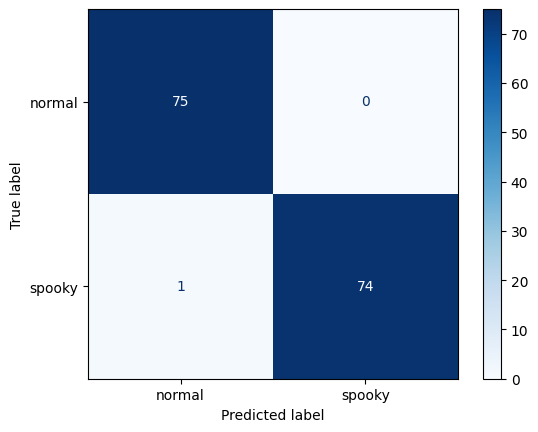

In [17]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay

model.eval()
all_preds, all_targets = [], []
with torch.no_grad():
    for x,y in test_loader:
        x = x.to(DEVICE)
        logits = model(x)
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        all_preds.extend(preds); all_targets.extend(y.numpy())

if len(all_targets)>0:
    from sklearn.metrics import accuracy_score
    acc = accuracy_score(all_targets, all_preds)
    prec, rec, f1, _ = precision_recall_fscore_support(all_targets, all_preds, average="binary", pos_label=1, zero_division=0)
    print(f"Test Accuracy: {acc:.3f} | Precision: {prec:.3f} | Recall: {rec:.3f} | F1: {f1:.3f}")
    cm = confusion_matrix(all_targets, all_preds)
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names).plot(cmap="Blues", values_format="d")
else:
    print("No test samples — check your split sizes.")

In [23]:
from torchvision import transforms as T
from PIL import Image
import numpy as np

def predict_haunted_level(img_path: str):
    model.eval()
    img = Image.open(img_path).convert("RGB")
    tfm = T.Compose([
        T.Resize((224,224)),
        T.ToTensor(),
        T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
    ])
    x = tfm(img).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        probs = torch.softmax(model(x), dim=1).cpu().numpy()[0]
    haunted = probs[1] * 100.0  # class 1 = spooky
    label = "spooky" if np.argmax(probs)==1 else "normal"
    return haunted, label

# Example test image from the spooky test folder
test_img = next((SPLIT_DIR/'test'/'spooky').glob('*')).as_posix()
hl, label = predict_haunted_level(test_img)
print(f"Haunted Level: {hl:.1f}% | Predicted: {label}")

Haunted Level: 99.9% | Predicted: spooky


## 🔥 Step 8 — Grad-CAM Visualization

In [24]:
# If running on Kaggle, Grad-CAM usually works directly.
# But if you need the package:
!pip install grad-cam -q


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 63.0 MB/s eta 0:00:00:00:010:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 58.4 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.2.6 which is incompatible.
gensim 4.3.3 requires scipy<1.14.0,>=1.7.0, but you have scipy 1.15.3 which is incompatible.
mkl-umath 0.1.1 requires numpy<1.27.0,>=1.26.4, but you have numpy 2.2.6 which is incompatible.
mkl-random 1.2.4 requires numpy<1.27.0,>=1.26.4, but you

In [31]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import numpy as np
import torch
from PIL import Image, ImageFile

# In case LOL has a few corrupt/truncated images:
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Last conv block in MobileNetV2
target_layer = model.features[-1]

# Broadcastable normalization tensors (1,3,1,1)
_MEAN = torch.tensor([0.485, 0.456, 0.406], dtype=torch.float32, device=DEVICE).view(1,3,1,1)
_STD  = torch.tensor([0.229, 0.224, 0.225], dtype=torch.float32, device=DEVICE).view(1,3,1,1)

def _to_input_tensor(img_pil, size=224):
    """PIL -> (display_img_float[0..1], normalized tensor[1,3,H,W] on DEVICE)"""
    img_resized = img_pil.convert("RGB").resize((size, size))
    img_np = np.array(img_resized).astype(np.float32) / 255.0              # (H,W,3) [0,1]
    x = torch.from_numpy(img_np.transpose(2,0,1)).unsqueeze(0).to(DEVICE)  # (1,3,H,W)
    x = (x - _MEAN) / _STD
    return img_np, x

def generate_gradcam(img_path, size=224, eigen_smooth=True, aug_smooth=True):
    model.eval()

    img_pil = Image.open(img_path).convert("RGB")
    img_disp, input_tensor = _to_input_tensor(img_pil, size=size)  # img_disp in [0,1]

    # Use predicted class as CAM target
    with torch.no_grad():
        logits = model(input_tensor)
        pred_class = int(logits.argmax(dim=1).item())

    targets = [ClassifierOutputTarget(pred_class)]

    # Use context manager to ensure proper hook cleanup
    with GradCAM(model=model, target_layers=[target_layer]) as cam:
        grayscale_cam = cam(
            input_tensor=input_tensor,
            targets=targets,
            eigen_smooth=eigen_smooth,
            aug_smooth=aug_smooth
        )[0]  # (H,W)

    cam_overlay = show_cam_on_image(img_disp, grayscale_cam, use_rgb=True)  # uint8 RGB
    return Image.fromarray((img_disp * 255).astype(np.uint8)), Image.fromarray(cam_overlay)

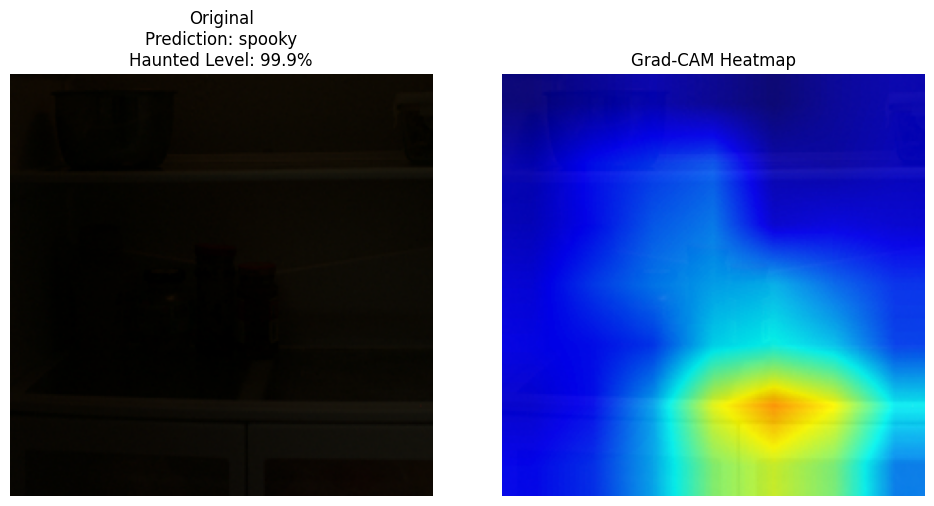

In [32]:
import matplotlib.pyplot as plt

def show_spooky_analysis(img_path):
    hl, label = predict_haunted_level(img_path)
    original, cam_img = generate_gradcam(img_path)

    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(original)
    plt.title(f"Original\nPrediction: {label}\nHaunted Level: {hl:.1f}%")
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(cam_img)
    plt.title("Grad-CAM Heatmap")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Try on a sample spooky test image
test_img = next((SPLIT_DIR/'test'/'spooky').glob('*'))
show_spooky_analysis(test_img.as_posix())